## Desafio Técnico Stone.

Mais detalhes:

https://github.com/Welltaytsohn/Projects_public/blob/master/Desafio%20Stone/Miss%C3%A3o%20Stone%20Janeiro%202019_Planejamento_Raul.pdf

### Objetivos:

##### 1- Criar um modelo de previsão de chargeback em operações financeiras com cartão.

##### 2- Consultas SQL.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 1- Modelo de previsão de possíveis estornos

Importação de alguns módulos que serão utilizados:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# disable warnings
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Leitura do arquivo:

In [2]:
df = pd.read_excel("Stone.xlsx")
df.head(3)

,Dia,Hora,Valor,Cartão,CBK
0,2015-05-01 00:00:00,00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
1,2015-05-01 00:00:00,00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
2,2015-05-01 00:00:00,00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,Não


Descrição das colunas e tipos de dados.

Já podemos notar que a coluna Hora contém valores NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128 entries, 0 to 11127
Data columns (total 5 columns):
Dia       11128 non-null object
Hora      10991 non-null object
Valor     11128 non-null float64
Cartão    11128 non-null object
CBK       11128 non-null object
dtypes: float64(1), object(4)
memory usage: 434.8+ KB


Uma boa prática é definir corretamente os tipos de dados, o código abaixo além de definir os dados como tipo 'datetime', padroniza os dados na coluna, ajustando dias, meses e anos que possam estar invertidos, além disso, transforma horários Am ou PM em formato 24h.

In [4]:
df.Dia = pd.to_datetime(df.Dia, dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128 entries, 0 to 11127
Data columns (total 5 columns):
Dia       11128 non-null datetime64[ns]
Hora      10991 non-null object
Valor     11128 non-null float64
Cartão    11128 non-null object
CBK       11128 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 434.8+ KB


 O dataset possui uma coluna de data(dia) e uma coluna de hora. No entanto, em alguns casos, as observações referentes a hora estão vazias mas contém o horário correto na coluna Dia. 

Algumas manipulações serão feitas para ajuste.

Primeiro separei as datas e horas em colunas diferentes:

In [5]:
df.Dia = df.Dia.astype(str)
df[['Data','Dia_hora']] = df.Dia.str.split(expand=True) 
df.head(3)

,Dia,Hora,Valor,Cartão,CBK,Data,Dia_hora
0,2015-05-01 00:00:00,00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não,2015-05-01,00:00:00
1,2015-05-01 00:00:00,00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não,2015-05-01,00:00:00
2,2015-05-01 00:00:00,00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,Não,2015-05-01,00:00:00


Então substituo todos os valores NaN da coluna 'Hora', pelos valores de horário correspondentes a eles que estão na coluna nova criada "Dia_hora".

Por fim confirmo se ainda há valores NaN no dataset.

In [6]:
df.loc[df['Hora'].isnull(),'Hora'] = df['Dia_hora']
df.drop(["Dia", "Dia_hora"],1, inplace= True)
df.isnull().values.any()

False

In [7]:
df.head(3)

,Hora,Valor,Cartão,CBK,Data
0,00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não,2015-05-01
1,00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não,2015-05-01
2,00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,Não,2015-05-01


In [8]:
df.describe()

,Valor
count,11128.000000
mean,129.550076
std,141.420554
min,1.000000
25%,55.000000
50%,99.000000
75%,154.000000
max,2920.000000


A coluna Valor possui média de 129,00 e valores mínimos de 1,00. Vou analisar a frequência em que esses valores aparecem e se essas orperações sofreram estorno.

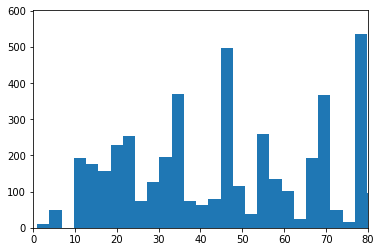

In [9]:
df.Valor.hist(bins = 1000, grid=False)
plt.xlim([0,80])
plt.show()

In [10]:
df2 = df[df['Valor']<10]
print(df2.shape)
df2

(60, 5)


,Hora,Valor,Cartão,CBK,Data
541,18:05:42,1.0,8d2926b2-6bb7-476e-9494-db5ea968a3a7,Não,2015-05-04
552,18:43:28,1.1,a3015d01-b6b0-4866-9711-b4630b495ff4,Não,2015-05-04
583,19:45:04,2.2,a3015d01-b6b0-4866-9711-b4630b495ff4,Não,2015-05-04
980,23:51:22,2.2,a642be2f-0fca-4990-a9fd-123415029dbe,Não,2015-05-05
1428,20:10:24,1.0,8d2926b2-6bb7-476e-9494-db5ea968a3a7,Não,2015-05-06
1493,22:34:47,1.0,a3015d01-b6b0-4866-9711-b4630b495ff4,Não,2015-05-06
6767,01:45:22,5.0,64382829-b444-4cb4-b459-feb69080e137,Não,2015-05-19
6793,10:27:53,5.0,d0e6ebd3-9c9f-4678-88da-ee85eb7fba8d,Não,2015-05-19
6805,10:45:01,5.0,d0e6ebd3-9c9f-4678-88da-ee85eb7fba8d,Não,2015-05-19
6809,10:52:21,5.0,7578d8e6-345d-4510-9d8a-7801a44c5e78,Não,2015-05-19


In [11]:
df2[df2['CBK']=='Sim'].shape

(0, 5)

Como visto, não temos estorno em operações menores que 10,00.

In [12]:
df[df.Valor<10].Valor.value_counts()

5.0    50
2.1     3
1.0     3
2.2     2
1.1     2
Name: Valor, dtype: int64

In [13]:
# indexNames = df[df['Valor']<10].index
# df.drop(indexNames , inplace=True)
# df[df['Valor']<10].shape

Aqui reorganizo as colunas para melhor visualização:

In [14]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head(3)

,Data,Hora,Valor,Cartão,CBK
0,2015-05-01,00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
1,2015-05-01,00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
2,2015-05-01,00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,Não


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128 entries, 0 to 11127
Data columns (total 5 columns):
Data      11128 non-null object
Hora      11128 non-null object
Valor     11128 non-null float64
Cartão    11128 non-null object
CBK       11128 non-null object
dtypes: float64(1), object(4)
memory usage: 434.8+ KB


Juntando as colunas de data e hora

In [16]:
df['Data'] = pd.to_datetime(df["Data"])
df['Data_Hora'] = df['Data'] + pd.to_timedelta(df['Hora'].astype(str))
df.drop(["Data", "Hora"],1, inplace= True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

df.head(3)

,Data_Hora,Valor,Cartão,CBK
0,2015-05-01 00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
1,2015-05-01 00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,Não
2,2015-05-01 00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,Não


Transformando a string 'Sim' e 'Não' em um vetor numérico representado por 0(não) e 1(sim)

In [17]:
df.replace({'CBK' : { 'Não' : 0, 'Sim' : 1 }},inplace= True)

cols = df.columns.tolist()
cols = cols[-5:] + cols[:-5]
df = df[cols]

df.head(3)

,Data_Hora,Valor,Cartão,CBK
0,2015-05-01 00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,0
1,2015-05-01 00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,0
2,2015-05-01 00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,0


Aqui transformo a variável 'cartão' em vetor numérico. Isso pode evitar alguns erros futuros se usarmos modelos que não reconhecem strings, além de deixar a coluna mais amigável para visualização. Note que aqui não acontece alteração nos dados, só estou renomeando cada cartão.

In [18]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:3].values
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

Uma forma de verificar se não houve alteração nos dados pela transformação é graficamente:

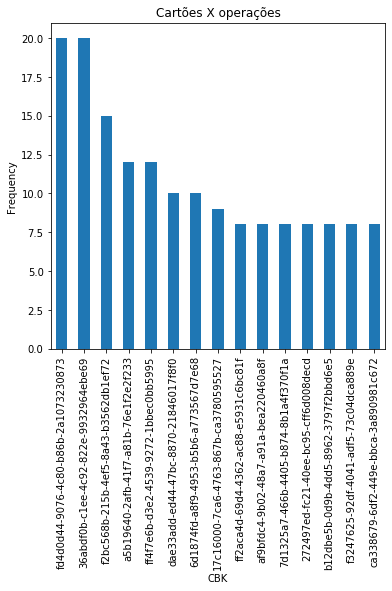

In [19]:
df['Cartão'].value_counts().head(15).plot(kind='bar', figsize=(6,6))
plt.title('Cartões X operações')
plt.xlabel('CBK')
plt.ylabel('Frequency')
plt.show()

In [20]:
df.Cartão = X
df.head(3)

,Data_Hora,Valor,Cartão,CBK
0,2015-05-01 00:01:54,36.54,1055,0
1,2015-05-01 00:03:46,36.54,1055,0
2,2015-05-01 00:08:50,69.00,2700,0


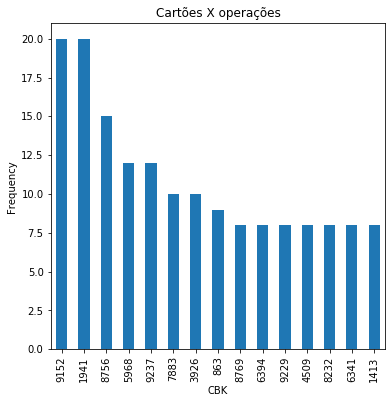

In [21]:
df['Cartão'].value_counts().head(15).plot(kind='bar', figsize=(6,6))
plt.title('Cartões X operações')
plt.xlabel('CBK')
plt.ylabel('Frequency')
plt.show()

#### Criando novos atributos

Aqui separei em colunas diferentes o dia, o dia da semana, hora, minuto e segundo.

In [22]:
df['day'] = df.Data_Hora.apply(lambda dt: dt.day)
df['day_week'] = df.Data_Hora.apply(lambda dt: dt.dayofweek)

df['hour'] = df.Data_Hora.apply(lambda dt: dt.hour)
df['minute'] = df.Data_Hora.apply(lambda dt: dt.minute)
df['second'] = df.Data_Hora.apply(lambda dt: dt.second)

# df.drop(["Data_Hora"],1, inplace= True)

df.head()

,Data_Hora,Valor,Cartão,CBK,day,day_week,hour,minute,second
0,2015-05-01 00:01:54,36.54,1055,0,1,4,0,1,54
1,2015-05-01 00:03:46,36.54,1055,0,1,4,0,3,46
2,2015-05-01 00:08:50,69.00,2700,0,1,4,0,8,50
3,2015-05-01 00:27:00,193.43,6678,0,1,4,0,27,0
4,2015-05-01 01:32:46,132.00,4703,0,1,4,1,32,46


Verificando se a operação acima gerou valores NaN:

In [23]:
for column in df:
    if df[column].isnull().any():
       print('{0} has {1} null values'.format(column, df[column].isnull().sum()))

### Análise Exploratória

##### Matriz de dispersão:


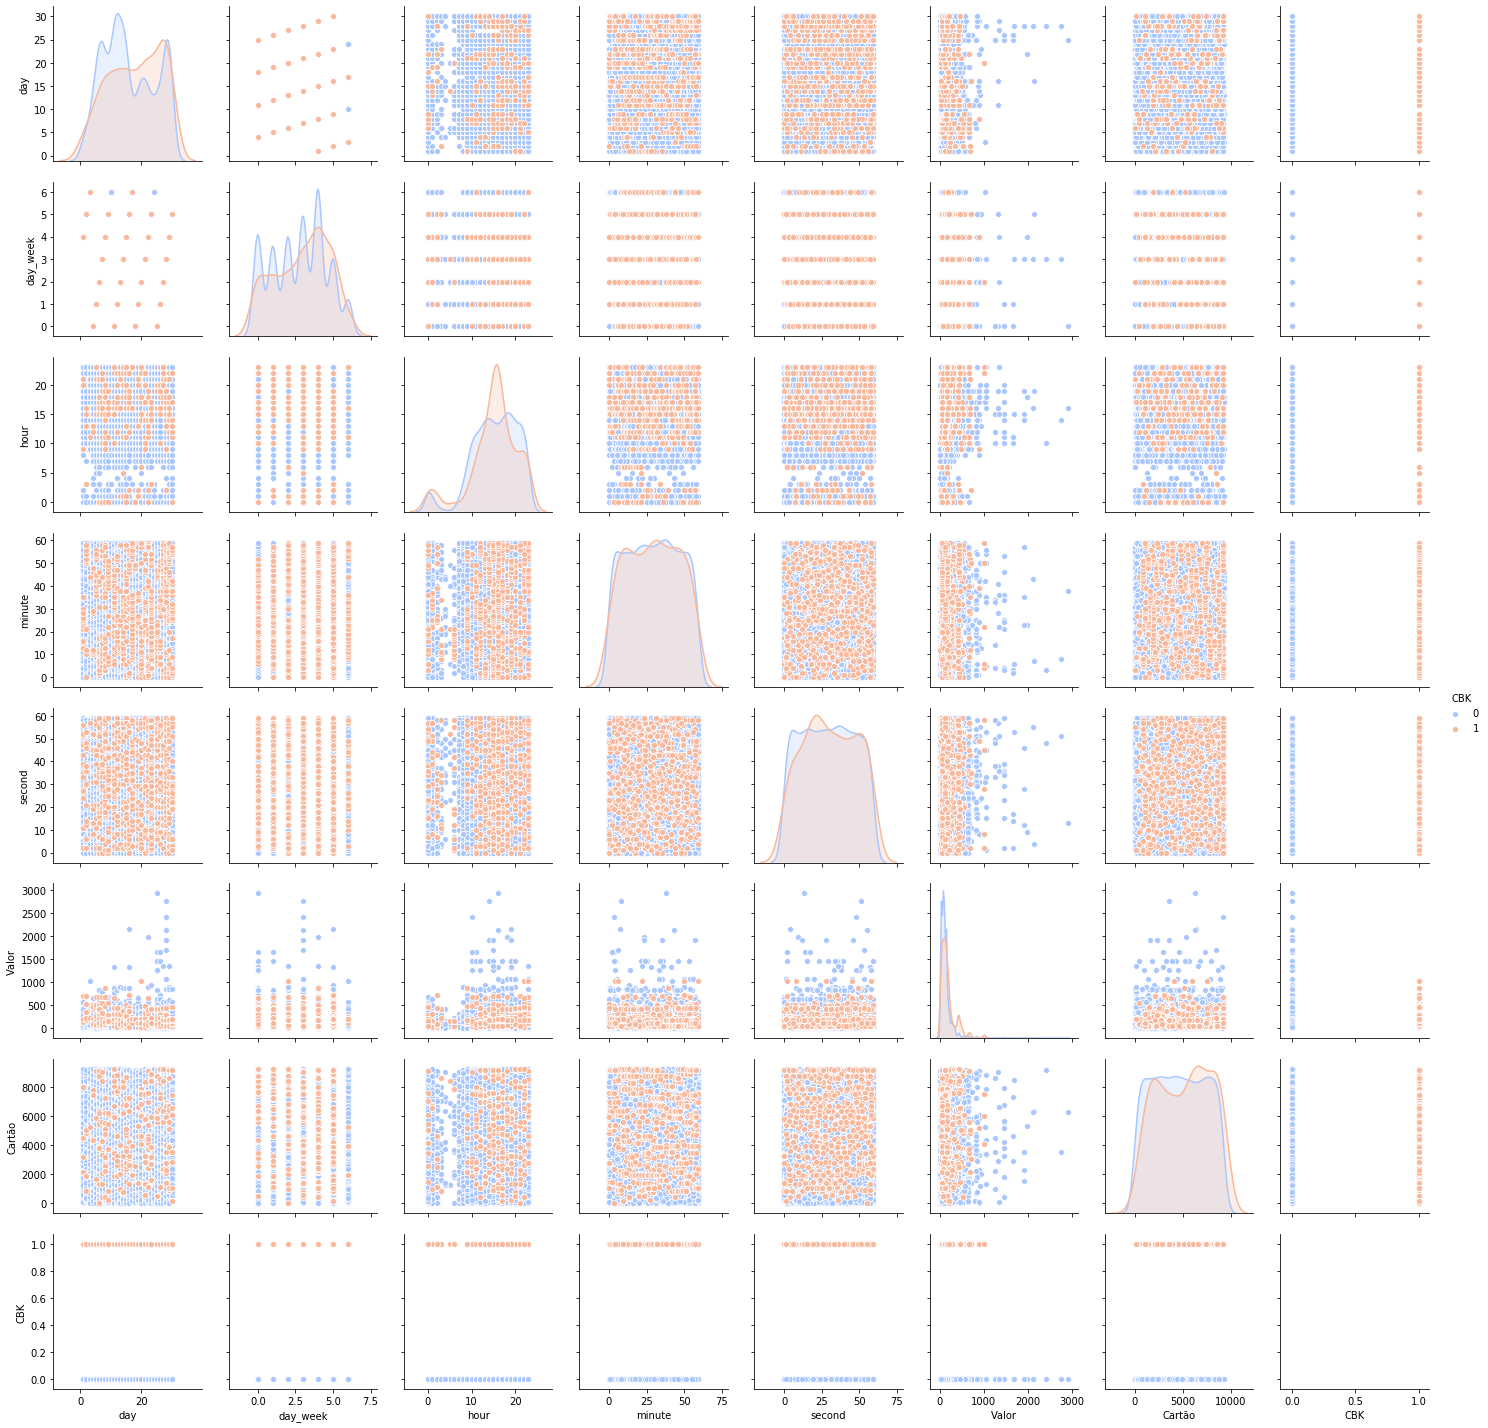

In [24]:
df = df[['day', 'day_week', 'hour', 'minute', 'second', 'Valor', 'Cartão', 'CBK' ]]
df.columns[:6]

sns.pairplot(df, hue='CBK',palette='coolwarm');

##### Histogramas:

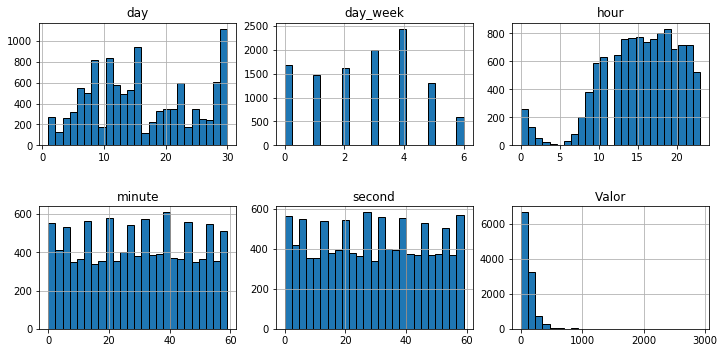

In [25]:
columns=df.columns[:6]
plt.subplots(figsize=(12,9))
length=len(columns)
for i,j in zip(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    df[i].hist(bins=25,edgecolor='black')
    plt.title(i)
plt.show()

Análise em casos de chargeback:

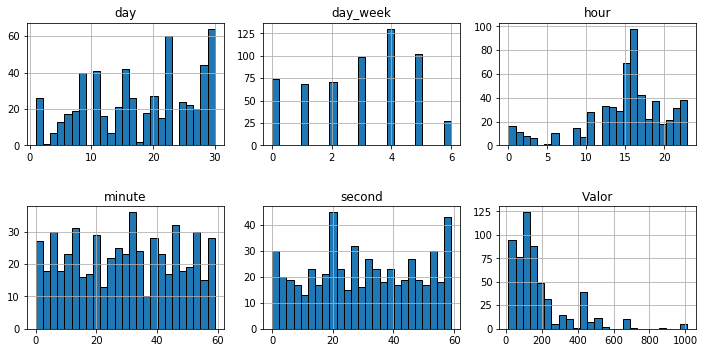

In [26]:
df1 = df[df['CBK']==1]
columns = df.columns[:6]
plt.subplots(figsize=(12,9))
length = len(columns)
for i,j in zip(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    df1[i].hist(bins=25,edgecolor='black')
    plt.title(i)
plt.show()

##### Distribuição da variável target:

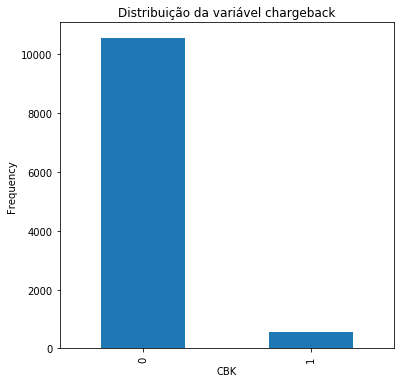

0    10556
1      572
Name: CBK, dtype: int64

In [27]:
df['CBK'] = df['CBK'].astype('category')

df['CBK'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Distribuição da variável chargeback')
plt.xlabel('CBK')
plt.ylabel('Frequency')
plt.show()

df.CBK.value_counts()

##### Correlação entre as variáveis numéricas:

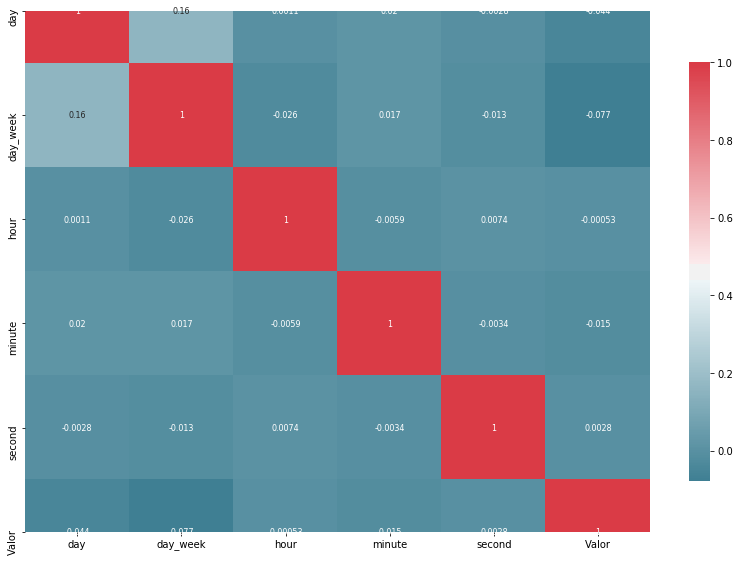

In [28]:
corr = df.corr()
_ , ax = plt.subplots( figsize =( 14 , 11 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .7 }, ax=ax, annot = True, annot_kws = {'fontsize' : 8 })

##### Outliers:

day            AxesSubplot(0.125,0.657941;0.227941x0.222059)
day_week    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
hour        AxesSubplot(0.672059,0.657941;0.227941x0.222059)
minute         AxesSubplot(0.125,0.391471;0.227941x0.222059)
second      AxesSubplot(0.398529,0.391471;0.227941x0.222059)
Valor       AxesSubplot(0.672059,0.391471;0.227941x0.222059)
dtype: object

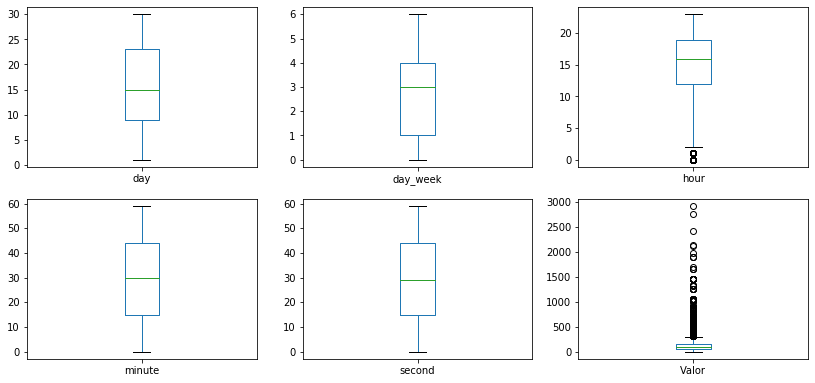

In [29]:
df.drop(['CBK', 'Cartão'], axis=1).plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10))

Cartões utlizados com e sem chargeback:

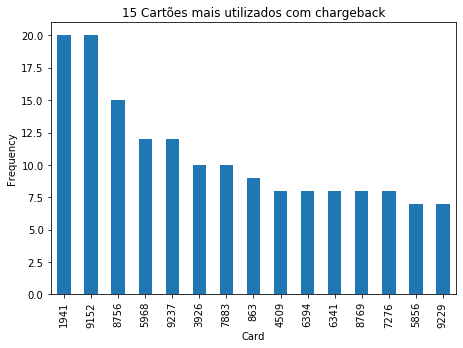

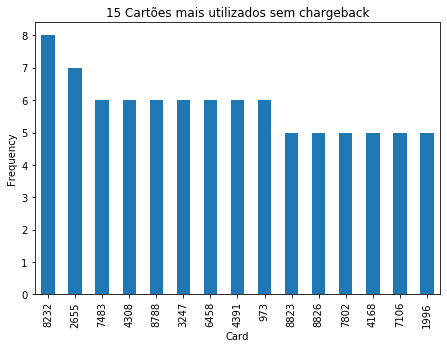

In [30]:
df1=df[df['CBK']==1]
plt.subplot(221)
df1['Cartão'].value_counts().head(15).plot(kind='bar', figsize=(16,11))
plt.title('15 Cartões mais utilizados com chargeback')
plt.xlabel('Card')
plt.ylabel('Frequency')
plt.show()

df2=df[df['CBK']==0]
plt.subplot(222)
df2['Cartão'].value_counts().head(15).plot(kind='bar', figsize=(16,11))
plt.title('15 Cartões mais utilizados sem chargeback')
plt.xlabel('Card')
plt.ylabel('Frequency')
plt.show()

In [31]:
from sklearn.feature_selection import VarianceThreshold

var_zero = VarianceThreshold(threshold=0)
var_zero.fit(df)
col_var_zero = [x for x in df.columns if x not in df.columns[var_zero.get_support()]]
print('Quantidade de variáveis com variância igual a zero:','\n', len(col_var_zero))
print("")
print("Variáveis com variância igual a zero e removidas:","\n", col_var_zero)

# get.support() retorna todas as colunas com variância diferente de zero:

df = df[df.columns[var_zero.get_support()]]
print("")
print('Shape dos dados:', df.shape)

Quantidade de variáveis com variância igual a zero: 
 0

Variáveis com variância igual a zero e removidas: 
 []

Shape dos dados: (11128, 8)


In [32]:
var_zero_ = VarianceThreshold(threshold=0.03)
var_zero_.fit(df)
col_var_zero_ = [x for x in df.columns if x not in df.columns[var_zero_.get_support()]]
print('Quantidade de variáveis com variância perto de zero:','\n', len(col_var_zero_))
print("")
print("Variáveis com variância perto de zero e removidas:","\n", col_var_zero_)

df = df[df.columns[var_zero_.get_support()]]
print('Shape dos dados:', df.shape)

Quantidade de variáveis com variância perto de zero: 
 0

Variáveis com variância perto de zero e removidas: 
 []
Shape dos dados: (11128, 8)


In [33]:
var_iguais = []

for i in range(len(df.columns)-1):
    v = df[df.columns[i]].values
    for j in range(i+1,len(df.columns)):
        if np.array_equal(v,df[df.columns[j]].values):
            print(df.columns[i],'=' ,df.columns[j])
            var_iguais.append(df.columns[j])
print("")
print('Colunas removidas:', var_iguais)  
df.drop(var_iguais, axis=1, inplace=True)
print("")
print('Shape dos dados:', df.shape)


Colunas removidas: []

Shape dos dados: (11128, 8)


In [34]:
df.columns

Index(['day', 'day_week', 'hour', 'minute', 'second', 'Valor', 'Cartão',
       'CBK'],
      dtype='object')

In [35]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df.drop(['Cartão','CBK'], axis=1), 0.9)
print('Variáveis correlacionadas e removidas: ', len(set(corr_features)))
print(corr_features)
df.drop(corr_features, axis=1, inplace=True)
print("")
print('Shape dos dados:', df.shape)

Variáveis correlacionadas e removidas:  0
set()

Shape dos dados: (11128, 8)


In [36]:
%%time

def detect_outlier(data, threshold=3):
    df_outlier = pd.DataFrame()
    
    for col in data.columns:
        mean, std = np.mean(data[col]), np.std(data[col])
        outliers=[]
        
        for y in data[col]:
            z_score = (y - mean)/std
            
            if np.abs(z_score) > threshold or np.abs(z_score) < -threshold:  
                outliers.append(y)
        df2 = pd.DataFrame({'variável': [col], 'quantidade': [len(set(outliers))]})
        df_outlier = df_outlier.append(df2)
        df_outlier = df_outlier.loc[df_outlier.quantidade > 0]  
          
    return df_outlier

outliers = detect_outlier(df.drop(['Cartão','CBK'], axis=1))

Wall time: 196 ms


In [37]:
outliers

,variável,quantidade
0,Valor,50


A variável valor contém 50 valores outliers distintos

In [38]:
df.sort_values('Valor', ascending=False).head(50).CBK.value_counts()

0    45
1     5
Name: CBK, dtype: int64

In [39]:
df.sort_values('Valor', ascending=False).head(50)[df.CBK==1]

,day,day_week,hour,minute,second,Valor,Cartão,CBK
7405,20,2,22,50,58,1012.0,7524,1
7410,20,2,22,59,8,1012.0,7524,1
7415,20,2,23,4,28,1012.0,4071,1
7418,20,2,23,6,2,1012.0,4071,1
7427,20,2,23,22,45,1012.0,5987,1


Essas compras foram realizadas no mesmo dia e em horários parecidos, em 3 cartões distintos e foram estornadas.

### Modelagem

In [40]:
numeric_columns = ['day', 'day_week', 'hour', 'minute', 'second', 'Valor']

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df[numeric_columns].values)
standardX = scaler.transform(df[numeric_columns].values)
df[numeric_columns] = standardX
round(df[numeric_columns].describe().T,3)

,count,mean,std,min,25%,50%,75%,max
day,11128.0,-0.0,1.0,-1.816,-0.854,-0.132,0.831,1.673
day_week,11128.0,-0.0,1.0,-1.551,-0.988,0.139,0.702,1.829
hour,11128.0,0.0,1.0,-2.962,-0.645,0.128,0.707,1.479
minute,11128.0,-0.0,1.0,-1.713,-0.839,0.036,0.852,1.727
second,11128.0,-0.0,1.0,-1.697,-0.830,-0.020,0.847,1.715
Valor,11128.0,0.0,1.0,-0.909,-0.527,-0.216,0.173,19.732


In [42]:
df.dtypes

day          float64
day_week     float64
hour         float64
minute       float64
second       float64
Valor        float64
Cartão        object
CBK         category
dtype: object

In [43]:
# np.random.seed(75)
# from imblearn.over_sampling import SMOTE, ADASYN
# X, Y = SMOTE().fit_sample(df, df.CBK)

In [45]:
if len(df[df.CBK==0]) > len(df[df.CBK==1]):
    df_ = pd.concat([df[df.CBK==0].sample(len(df[df.CBK==1])),
                         df[df.CBK==1]], ignore_index=True)
else:
    df_ = pd.concat([df[df.CBK==1].sample(len(df[df.CBK==0])),
                         df[df.CBK==0]], ignore_index=True)
    
df_.CBK.value_counts()

1    572
0    572
Name: CBK, dtype: int64

KNN: 0.761463 0.808796 (0.037407)
LR: 0.662380 0.752571 (0.048871)
LDA: 0.657943 0.720443 (0.041327)
CART: 0.792554 0.845938 (0.030695)
XGB : 0.905602 0.955049 (0.029834)


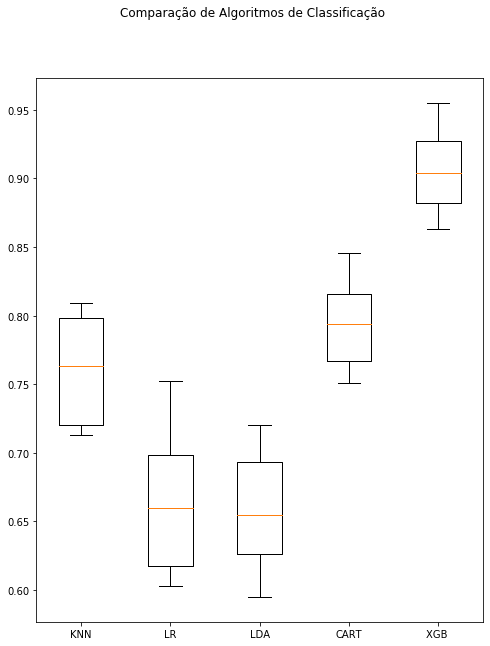

Wall time: 2.68 s


In [46]:
%%time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

X = df_.drop(['CBK'], axis=1).values
Y = df_.CBK.values

num_folds = 10

modelos = []
resultados = []
nomes = []

modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('XGB ', XGBClassifier()))


for nome, modelo in modelos:
    kfold = KFold(num_folds, True)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f %f (%f)" % (nome, cv_results.mean(), cv_results.max(), cv_results.std())
    print(msg)


fig = plt.figure(figsize= (8,10))
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

In [49]:
for nome, modelo in modelos:
    kfold = KFold(num_folds, True)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f %f (%f)" % (nome, cv_results.mean(), cv_results.max(), cv_results.std())
    print(msg)


KNN: 0.956954 0.968553 (0.005439)
LR: 0.947790 0.958670 (0.007625)
LDA: 0.945363 0.955076 (0.005713)
CART: 0.952011 0.965858 (0.007235)
XGB : 0.974480 0.983813 (0.005175)


In [57]:
from sklearn.ensemble import ExtraTreesClassifier

X = df_.drop(['CBK'], axis=1).values
Y = df_.CBK.values

modelo = ExtraTreesClassifier()
modelo.fit(X, Y);

X_train = df.drop('CBK', axis=1)
features = [col for col in list(X_train) ]
importances =  modelo.feature_importances_
descending_indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in descending_indices]
sorted_features = [features[idx] for idx in descending_indices]
print('As características mais importantes são %s' % sorted_features[0:3])

As características mais importantes são ['Valor', 'Cartão', 'hour']


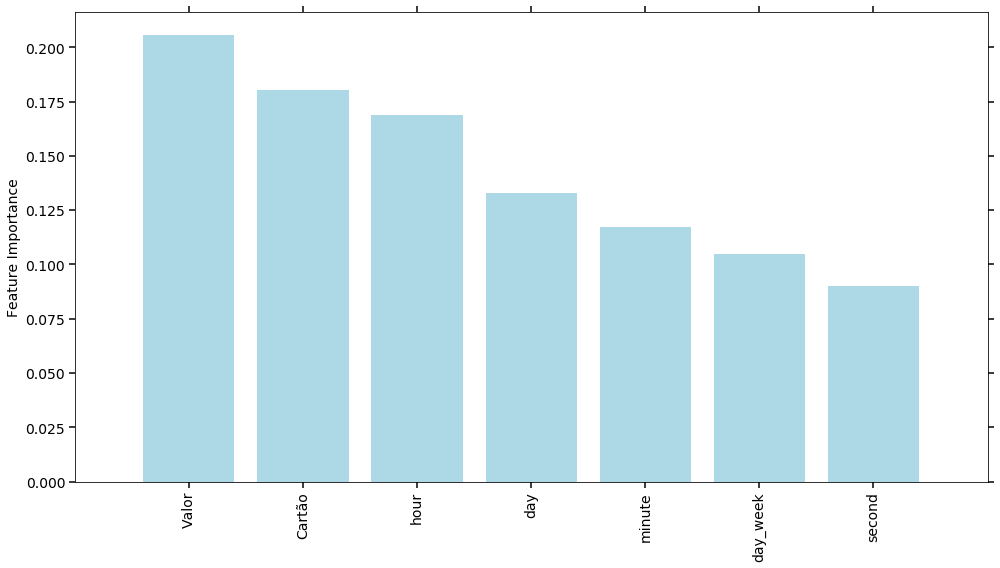

In [58]:

def plot_importances(X_train, sorted_features, sorted_importances):

    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'
    ax = plt.bar(range(X_train.shape[1]), sorted_importances, color=bar_color, align=align, label=label)
    ax = plt.xticks(range(X_train.shape[1]), sorted_features, rotation=90)
    ax = plt.xlim([-1, X_train.shape[1]])
    ax = plt.ylabel('Feature Importance', fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

fig1 = plt.figure(1, figsize=(14,8))
ax = plot_importances(X_train, sorted_features, sorted_importances)

plt.show()

In [59]:
X = df_.drop(['CBK'], axis=1).values
Y = df_.CBK.values

num_folds = 15
kfold = KFold(num_folds, True)

modelo = XGBClassifier()

resultado = cross_val_score(modelo, X, Y, cv = kfold)

print('\n', "Acurácia: %.3f%%" % (resultado.mean() * 100.0), '\n',
      'max:', (resultado.max() * 100.0), '\n',                          
      'STD:',resultado.std(), '\n')

resultado = cross_val_score(modelo, X, Y, cv = kfold, scoring='roc_auc')

print('\n', "Auc: %.3f%%" % (resultado.mean() * 100.0), '\n',
      'max:', (resultado.max() * 100.0), '\n',                          
      'STD:',resultado.std(), '\n')


 Acurácia: 83.391% 
 max: 89.47368421052632 
 STD: 0.03314480299935123 


 Auc: 90.828% 
 max: 94.6341463414634 
 STD: 0.02284270436018753 



In [60]:
modelo.fit(X,Y);

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Aplicação do modelo nos dados de teste do mês seguinte:

##### Fazendo as previsões nos dados de Junho de 2015 (Aba2)


In [69]:
df_test = pd.read_excel("Stone.xlsx", sheet_name='Aba 2')
df_test.Dia = pd.to_datetime(df_test.Dia)
df_test['Dia'] = pd.to_datetime(df_test["Dia"])
df_test['Data_Hora'] = df_test['Dia'] + pd.to_timedelta(df_test['Hora'].astype(str))
df_test.drop(["Dia", "Hora"],1, inplace= True)

df_test['day'] = df_test.Data_Hora.apply(lambda dt: dt.day)
df_test['hour'] = df_test.Data_Hora.apply(lambda dt: dt.hour)
df_test['minute'] = df_test.Data_Hora.apply(lambda dt: dt.minute)
df_test['second'] = df_test.Data_Hora.apply(lambda dt: dt.second)

df_test.drop(["Data_Hora"],1, inplace= True)

df_test = df_test[['day', 'day_week', 'hour', 'minute', 'second', 'Valor', 'Cartão', 'CBK' ]]

from sklearn.preprocessing import LabelEncoder
X = df_test.iloc[:, 6:7].values
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

df_test.Cartão = X

df_test.head()

,day,day_week,hour,minute,second,Valor,Cartão,CBK
0,1,1,0,2,25,112.00,3416,0
1,1,1,0,30,45,112.00,7924,0
2,1,1,0,43,20,18.34,2714,0
3,1,1,0,46,46,55.00,8446,0
4,1,1,0,47,50,50.00,6255,0


In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11820 entries, 0 to 11819
Data columns (total 8 columns):
day         11820 non-null int64
day_week    11820 non-null int64
hour        11820 non-null int64
minute      11820 non-null int64
second      11820 non-null int64
Valor       11820 non-null float64
Cartão      11820 non-null object
CBK         11820 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 738.9+ KB


Verificando a existência de valores NaN:

In [71]:
df_test.drop('CBK', axis=1).isnull().values.any()

False

Analisando a quantidade de operações que, provavelmente, são de validação de cartão:

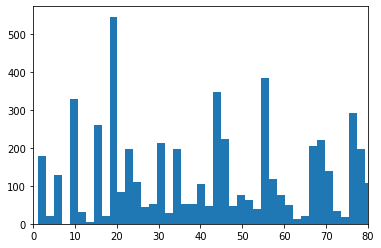

In [72]:
df_test.Valor.hist(bins = 1000, grid=False)
plt.xlim([0,80])
plt.show()

##### Fazendo as previsões e analisando os resultados:

In [74]:
X_teste = df_test.drop('CBK', axis=1)

In [79]:
scaler = StandardScaler().fit(X_teste[numeric_columns].values)
standardX = scaler.transform(X_teste[numeric_columns].values)
X_teste[numeric_columns] = standardX
round(X_teste[numeric_columns].describe().T,3)

,count,mean,std,min,25%,50%,75%,max
day,11820.0,0.0,1.0,-1.840,-0.665,0.119,0.902,1.816
day_week,11820.0,0.0,1.0,-1.796,-0.665,-0.100,1.031,1.597
hour,11820.0,-0.0,1.0,-2.916,-0.644,0.113,0.871,1.439
minute,11820.0,0.0,1.0,-1.723,-0.856,0.011,0.879,1.688
second,11820.0,0.0,1.0,-1.719,-0.845,0.028,0.844,1.718
Valor,11820.0,-0.0,1.0,-0.996,-0.620,-0.172,0.270,15.704


In [81]:
predict = modelo.predict(X_teste.values)
df_test['predict'] = predict

In [85]:
df_test.CBK.value_counts()

0    11820
Name: CBK, dtype: int64

In [86]:
df_test.predict.value_counts()

0    9195
1    2625
Name: predict, dtype: int64

Comparando a quantidade de chargeback no mês anterior (dados reais) e no mês seguinte (previsto):

In [89]:
df.CBK.value_counts(normalize=True)

0    0.948598
1    0.051402
Name: CBK, dtype: float64

In [90]:
df_test.predict.value_counts(normalize=True)

0    0.777919
1    0.222081
Name: predict, dtype: float64

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 2- Consultas SQL

In [94]:
! pip install pymysql

In [95]:
import pymysql

# Conexão ao banco de dados
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='Mysqlsenha123',                             
                             db='banco')

A- Faça a query que retorna os dados da mesma forma da planilha da parte I:

In [96]:
# Query
query = '''

select date(`TransactionDate`) as Dia, time_format(`TransactionDate`, "%T") as Hora,
`Amount` as Valor, `CardNumber` as Cartão,
CASE
    WHEN chargebackDate is not null then 'sim'
    else 'não'
end as CBK
from transactions
left join chargeback on transactions.Id = chargeback.TransactionId  

'''

# Dataframe
query_1 = pd.read_sql(query, connection)
query_1.head(3)

,Dia,Hora,Valor,Cartão,CBK
0,2015-05-01,00:01:54,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,não
1,2015-05-01,00:03:46,36.54,1c8a66eb-912b-40b8-a44d-f7adad325ad5,não
2,2015-05-01,00:08:50,69.00,4baca9d8-d3c2-4ecc-80e2-e5effd8f4247,não


B- Faça uma query que retorna a quantidade e a soma das transações que retornaram chargeback:

In [97]:
query_2 = '''

select count(*) as 'Quantidade', round(sum(Amount),2) as 'Soma CBK'
from transactions
left join chargeback on transactions.Id = chargeback.TransactionId
where ChargebackDate is not null 

'''

# Dataframe
query_2 = pd.read_sql(query_2, connection)
query_2.head(3)

,Quantidade,Soma CBK
0,572,104847.86


C- Faça uma query que retorna o índice de chargeback em quantidade e em valor. (Índice = Chargeback/Vendas):

In [98]:
query_3 = '''

select

concat(format((select count(*) as 'Quantidade' from transactions left join chargeback on transactions.Id = chargeback.TransactionId
where ChargebackDate is not null) / count(*), 3), '%') as 'Índice QNT CBK',

concat(format((select sum(Amount) as 'soma_cbk' from transactions left join chargeback on transactions.Id = chargeback.TransactionId
where ChargebackDate is not null) / sum(Amount), 3), '%') as 'Índice soma CBK'

from transactions left join chargeback on transactions.Id = chargeback.TransactionId

'''

# Dataframe
query_3 = pd.read_sql(query_3, connection)
query_3.head(3)

,Índice QNT CBK,Índice soma CBK
0,0.051%,0.073%


#### Fim